<a href="https://colab.research.google.com/github/ymkge/competiton/blob/main/LightGBM%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3%E4%BD%9C%E6%88%90_%202%E5%80%A4%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## モジュールのインストール

In [ ]:
!pip install shap

## ライブラリのインポート

In [ ]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import shap
pd.set_option('display.max_rows', 100)
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## データの準備

In [42]:
# Breast Cancer をsklearnのdatasetsから読み込む
bc = datasets.load_breast_cancer()
X = pd.DataFrame(bc.data, columns=bc.feature_names) # 説明変数を設定
y = pd.DataFrame(bc.target) # 目的変数を設定

# 件数と項目数の確認
print(X.shape)
print(y.shape)

## モデルの学習と保存

In [52]:
# 訓練データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y)

# lightgbm用のデータセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM のハイパーパラメータ
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'verbosity': -1
}

# モデルの学習
vervose_evel = 20 # ここで学習時のスコア推移がコマンドライン表示(-1:最終行の表示, 0:表示なし, 1:1行ずつ表示, 20:20行ずつ表示)
model = lgb.train(params,
                  lgb_train,
                  valid_sets=lgb_eval,
                  callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
                  lgb.log_evaluation(vervose_evel)] # コマンドライン出力用コールバック関数
)

# モデルの保存
model.save_model('model.txt')

Training until validation scores don't improve for 10 rounds
[20]	valid_0's binary_logloss: 0.268572
[40]	valid_0's binary_logloss: 0.147062
[60]	valid_0's binary_logloss: 0.102402
[80]	valid_0's binary_logloss: 0.0829772
[100]	valid_0's binary_logloss: 0.0767005
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0761609


## モデルを使った予測と評価

AUC: 0.9968553459119497


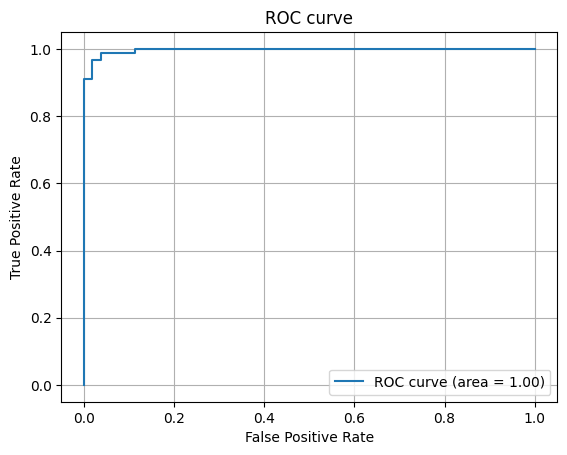

In [62]:
# テストデータを使って予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# AUC (Area Under the Curve) を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(f'AUC: {auc}')

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## モデルで算出された変数重要度を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

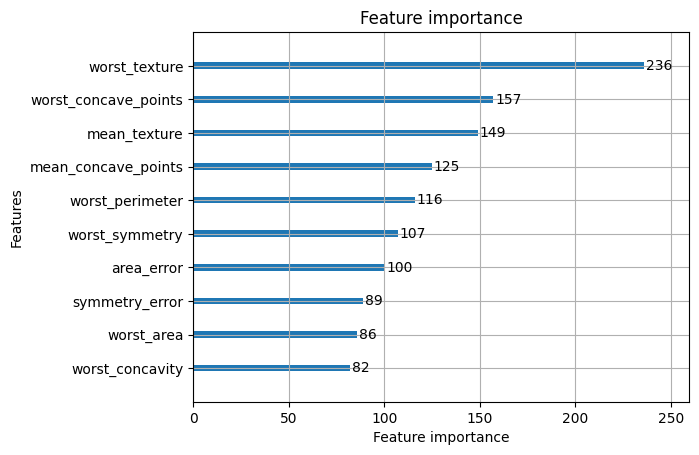

In [72]:
# 特徴量の重要度を棒グラフで可視化(max_num_featuresで重要度の高い10項目のみ出力)
lgb.plot_importance(model, max_num_features=10)

## shapで目的変数への項目毎の寄与度を確認

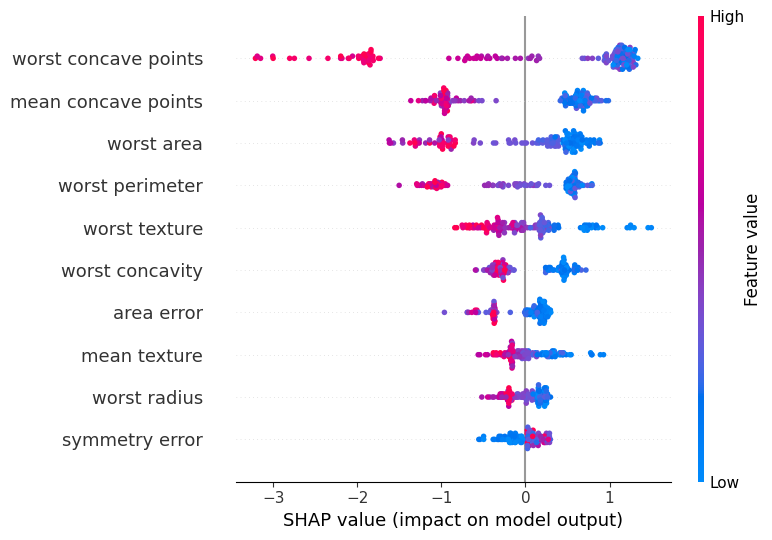

--


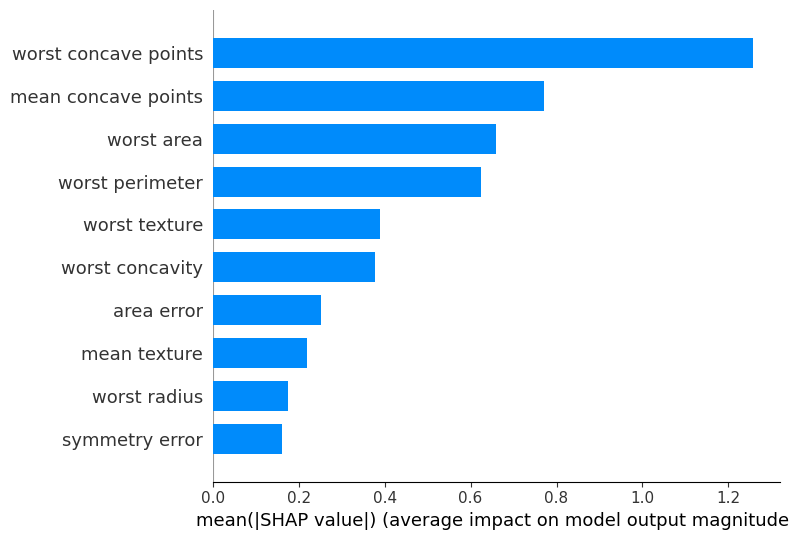

In [76]:
# shap値を使用して、各説明変数の重要度や寄与度を可視化
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# summary_plotのmax_displayで寄与度の高い10項目まで出力)
shap.summary_plot(shap_values, X_test, max_display=10)
print('--')
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=10)